In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
ticker = "AAPL"
df = pd.read_csv(f'../data/{ticker}_engineered_features.csv', index_col='Date', parse_dates=True)

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nFirst few rows:")
df.head()

Loaded data shape: (1058, 46)
Date range: 2020-10-15 00:00:00 to 2024-12-30 00:00:00

First few rows:


,Close,High,Low,Open,Volume,price_lag1,price_lag2,price_lag3,price_lag5,price_change,...,volume_ratio,volume_change,OBV,STOCH_k,STOCH_d,ATR,CCI,WILLR,target,target_direction
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-15,117.193405,117.669128,114.707987,115.261381,112559200,117.659401,117.572029,120.775909,111.620605,-0.465996,...,0.728708,-0.253150,1655531000,64.464778,73.240989,4.092155,103.510148,-35.535222,115.552612,0
2020-10-16,115.552612,118.008913,115.348731,117.746774,115393800,117.193405,117.659401,117.572029,113.562378,-1.640793,...,0.791026,0.025183,1540137200,51.632365,64.131687,3.989871,90.707574,-48.367635,112.601196,0
2020-10-19,112.601196,116.911842,112.290519,116.465244,120639300,115.552612,117.193405,117.659401,120.775909,-2.951416,...,0.848826,0.045457,1419497900,28.549750,48.215631,4.034975,36.543517,-71.450250,114.086632,1
2020-10-20,114.086632,115.513808,112.261396,112.814790,124423700,112.601196,115.552612,117.193405,117.572029,1.485435,...,0.893891,0.031370,1543921600,40.167135,40.116417,3.979078,31.514647,-59.832865,113.465286,0
2020-10-21,113.465286,115.251679,113.057516,113.271108,89946000,114.086632,112.601196,115.552612,117.659401,-0.621346,...,0.660616,-0.277099,1453975600,35.307678,34.674854,3.851584,23.592771,-64.692322,112.377884,0


Select features for modelling

In [4]:
feature_columns = [
    # Price features
    'Close', 'price_lag1', 'price_lag2', 'price_lag3', 'price_lag5', 'open_close_pct', 'high_low_pct',

    # Moving averages
    'MA5', 'MA10', 'MA20', 'MA50', 'MA5_MA20_diff', 'price_to_MA20', 'price_to_MA50',

    # Momentum indicators
    'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'STOCH_k', ' STOCH_d', 'CCI', 'WILLR',

    # Volatility
    'ATR', 'BB_wdith', 'BB_position',

    # Volume
    'volume_ratio', 'volume_change', 'OBV'
]

# Check which features actually exist in our dataset
available_features = [col for col in feature_columns if col in df.columns]
missing_features = [col for col in feature_columns if col not in df.columns]

print(f"Available features: {len(available_features)}")
print(f"Missing features: {len(missing_features)}")
if missing_features:
    print(f"Missing: {missing_features}")

# Use available features
X = df[available_features].copy()
y = df['target'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

Available features: 26
Missing features: 2
Missing: [' STOCH_d', 'BB_wdith']

Feature matrix shape: (1058, 26)
Target shape: (1058,)


Handle missing values and prepare data

In [5]:
# Check for any remaining NaN values
print("Missing values:")
print(X.isnull().sum().sum(), "in features")
print(y.isnull().sum(), "in target")

# Drop rows with NaN in either X or y
valid_indices = X.notna().all(axis=1) & y.notna()
X = X[valid_indices]
y = y[valid_indices]

print(f"\nAfter removing NaN:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Missing values:
0 in features
0 in target

After removing NaN:
Features shape: (1058, 26)
Target shape: (1058,)


Train/Test Split

Training set: 846 samples
Test set: 212 samples

Training period: 2020-10-15 00:00:00 to 2024-02-27 00:00:00
Test period: 2024-02-28 00:00:00 to 2024-12-30 00:00:00


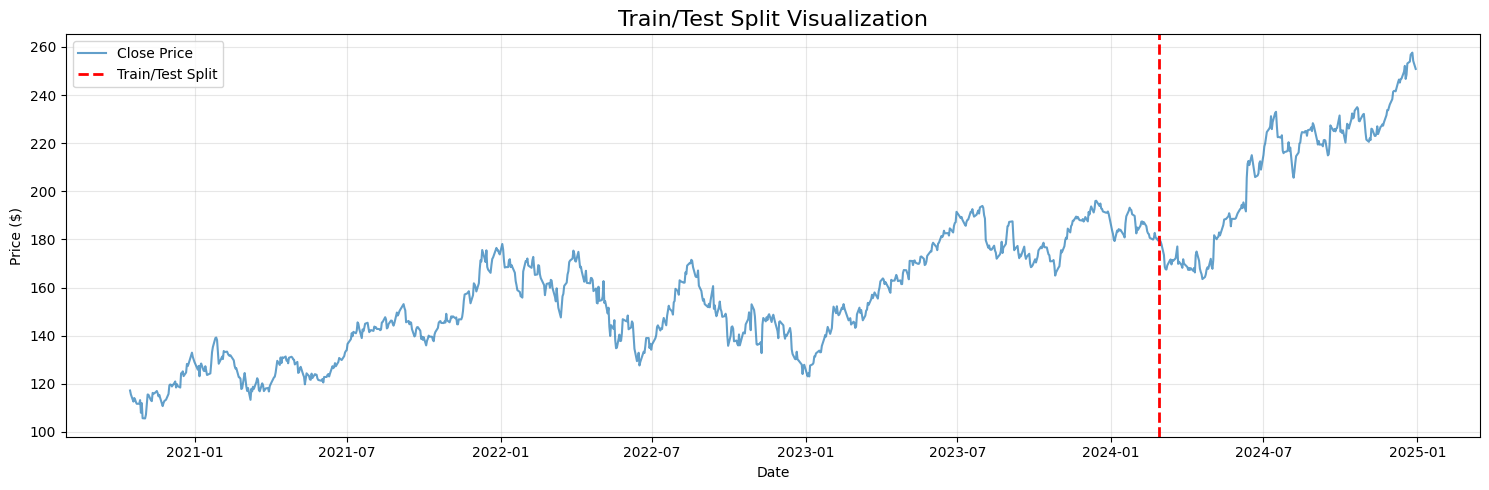

In [6]:
# Train on past data, test on future data
# 80% for training, 20% for testing
split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining period: {X_train.index[0]} to {X_train.index[-1]}")
print(f"Test period: {X_test.index[0]} to {X_test.index[-1]}")

# Visualize the split
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.7)
plt.axvline(x=X_train.index[-1], color='red', linestyle='--', linewidth=2, label='Train/Test Split')
plt.title('Train/Test Split Visualization', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Scale features to same range
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully!")
print(f"\nExample - Clsoe price before scaling: {X_train['Close'].iloc[0]:.2f}")
print(f"Example - Close price after scaling: {X_train_scaled['Close'].iloc[0]:.2f}")

Features scaled successfully!

Example - Clsoe price before scaling: 117.19
Example - Close price after scaling: -1.59


# Basline Model #1 - Linear Regression

In [10]:
print("="*60)
print("MODEL 1: LINEAR REGRESSION")
print("="*60)

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Calculate metrics
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print(f"\nTraining Performance:")
print(f"  RMSE: ${train_rmse_lr:.2f}")
print(f"  MAE: ${train_mae_lr:.2f}")
print(f"  R² Score: {train_r2_lr:.4f}")

print(f"\nTest Performance:")
print(f"  RMSE: ${test_rmse_lr:.2f}")
print(f"  MAE: ${test_mae_lr:.2f}")
print(f"  R² Score: {test_r2_lr:.4f}")

MODEL 1: LINEAR REGRESSION

Training Performance:
  RMSE: $2.53
  MAE: $1.91
  R² Score: 0.9868

Test Performance:
  RMSE: $3.17
  MAE: $2.44
  R² Score: 0.9850


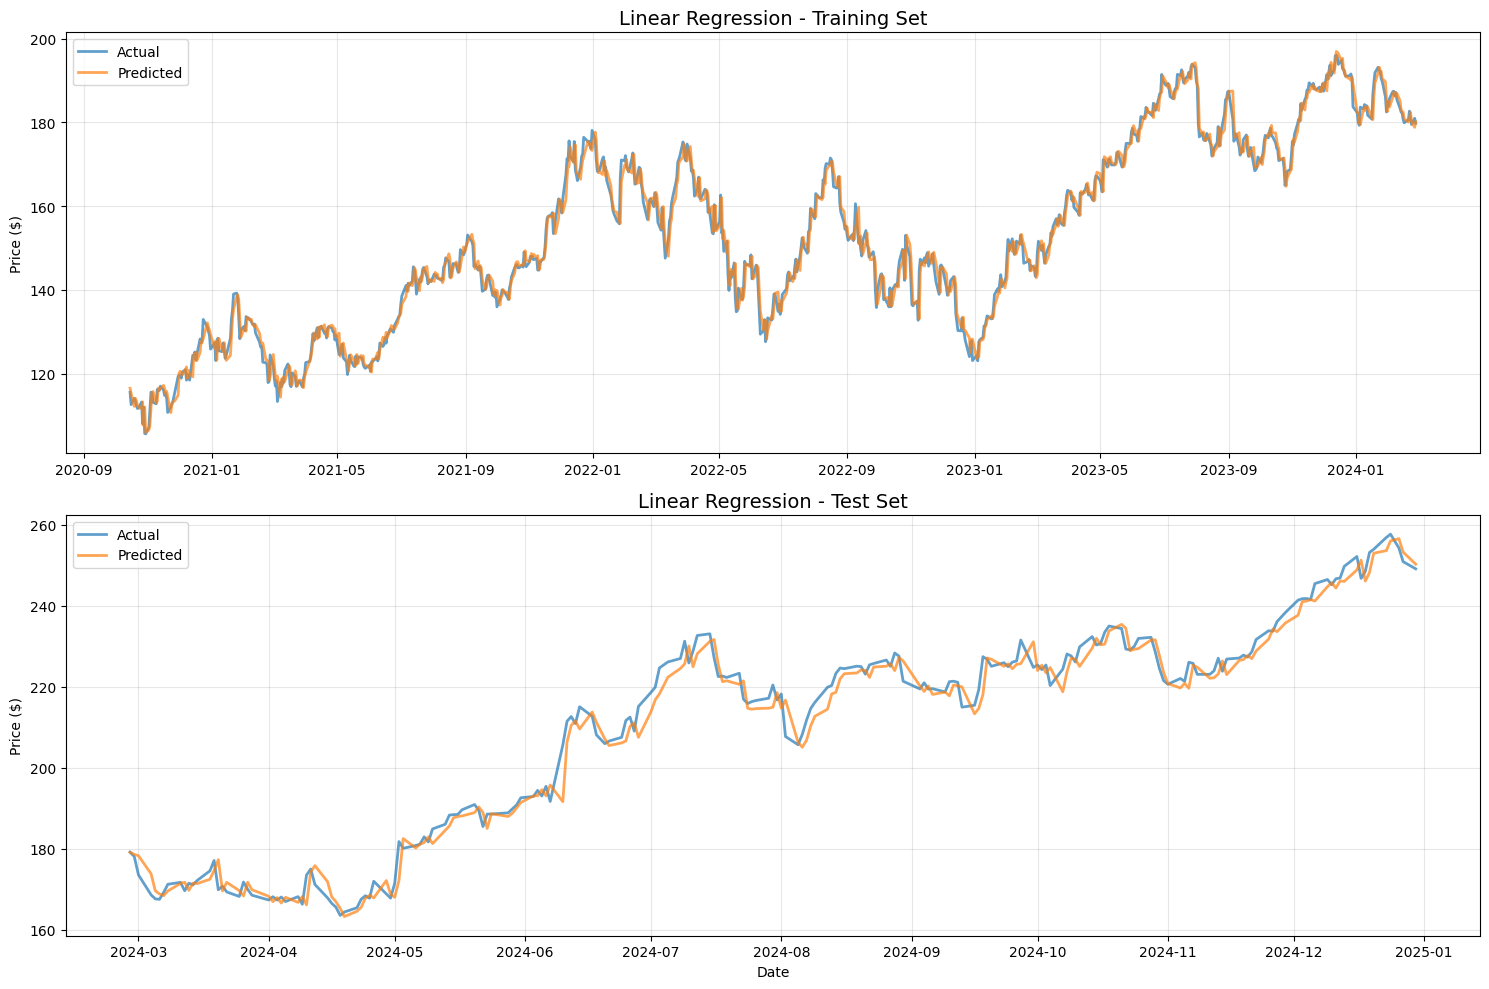

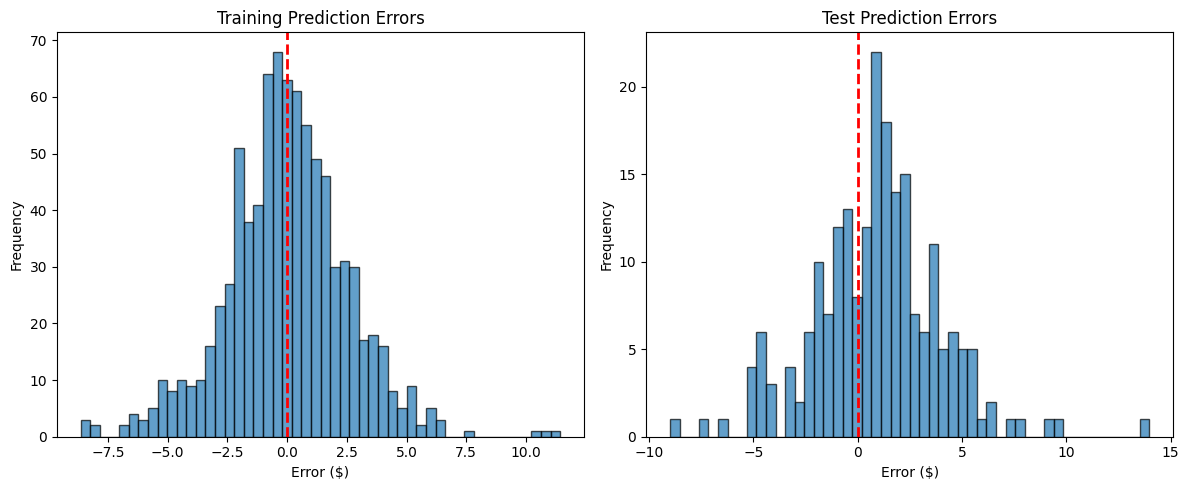

In [12]:
# Plot predictions vs actual
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Training set
ax1.plot(y_train.index, y_train.values, label='Actual', linewidth=2, alpha=0.7)
ax1.plot(y_train.index, y_train_pred_lr, label='Predicted', linewidth=2, alpha=0.7)
ax1.set_title('Linear Regression - Training Set', fontsize=14)
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test set
ax2.plot(y_test.index, y_test.values, label='Actual', linewidth=2, alpha=0.7)
ax2.plot(y_test.index, y_test_pred_lr, label='Predicted', linewidth=2, alpha=0.7)
ax2.set_title('Linear Regression - Test Set', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Price ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Prediction error distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_errors = y_train - y_train_pred_lr
plt.hist(train_errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Training Prediction Errors')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
test_errors = y_test - y_test_pred_lr
plt.hist(test_errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Test Prediction Errors')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

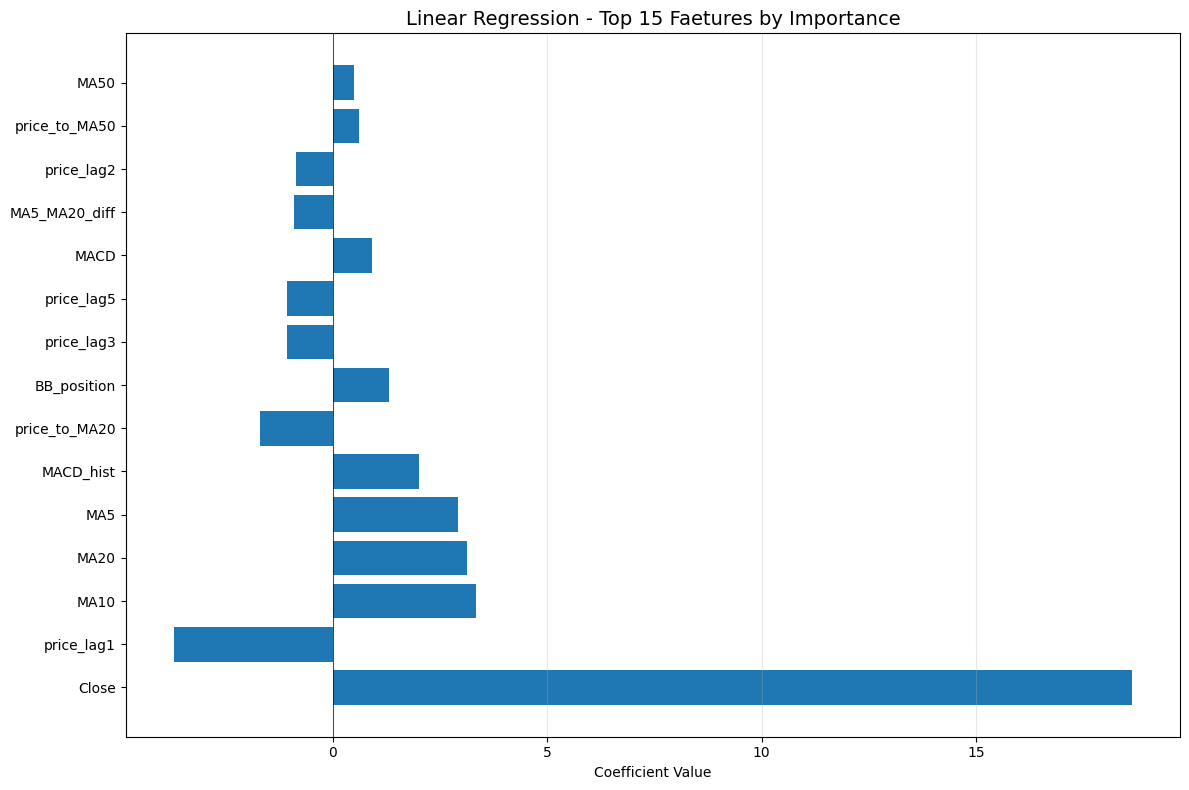


Top 10 Most Important Features:
      feature  coefficient
0       Close    18.642338
1  price_lag1    -3.710478
8        MA10     3.333629
9        MA20     3.138434
7         MA5     2.913959


In [15]:
# Look at which features the model thinks are important
feature_importance_lr = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr_model.coef_
})
feature_importance_lr['abs_coefficient'] = np.abs(feature_importance_lr['coefficient'])
feature_importance_lr = feature_importance_lr.sort_values('abs_coefficient', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
top_features = feature_importance_lr.head(15)
plt.barh(range(len(top_features)), top_features['coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Linear Regression - Top 15 Faetures by Importance', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance_lr.head()[['feature', 'coefficient']])

# Model 2 - Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor

print("="*60)
print("MODEL 2: RANDOM FOREST")
print("="*60)

# Train Random Forest
# n_estimators = number of trees
# max_depth = how deep each tree can go
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1 # Use all CPU cores
)

print("Training Random Forest...")
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Calculate metrics
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print(f"\nTraining Performance:")
print(f"  RMSE: ${train_rmse_rf:.2f}")
print(f"  MAE: ${train_mae_rf:.2f}")
print(f"  R² Score: {train_r2_rf:.4f}")

print(f"\nTest Performance:")
print(f"  RMSE: ${test_rmse_rf:.2f}")
print(f"  MAE: ${test_mae_rf:.2f}")
print(f"  R² Score: ${test_r2_rf:.4f}")

print(f"\n Random Forest trained successfully!")

MODEL 2: RANDOM FOREST
Training Random Forest...

Training Performance:
  RMSE: $1.28
  MAE: $0.93
  R² Score: 0.9966

Test Performance:
  RMSE: $27.70
  MAE: $21.92
  R² Score: $-0.1414

 Random Forest trained successfully!


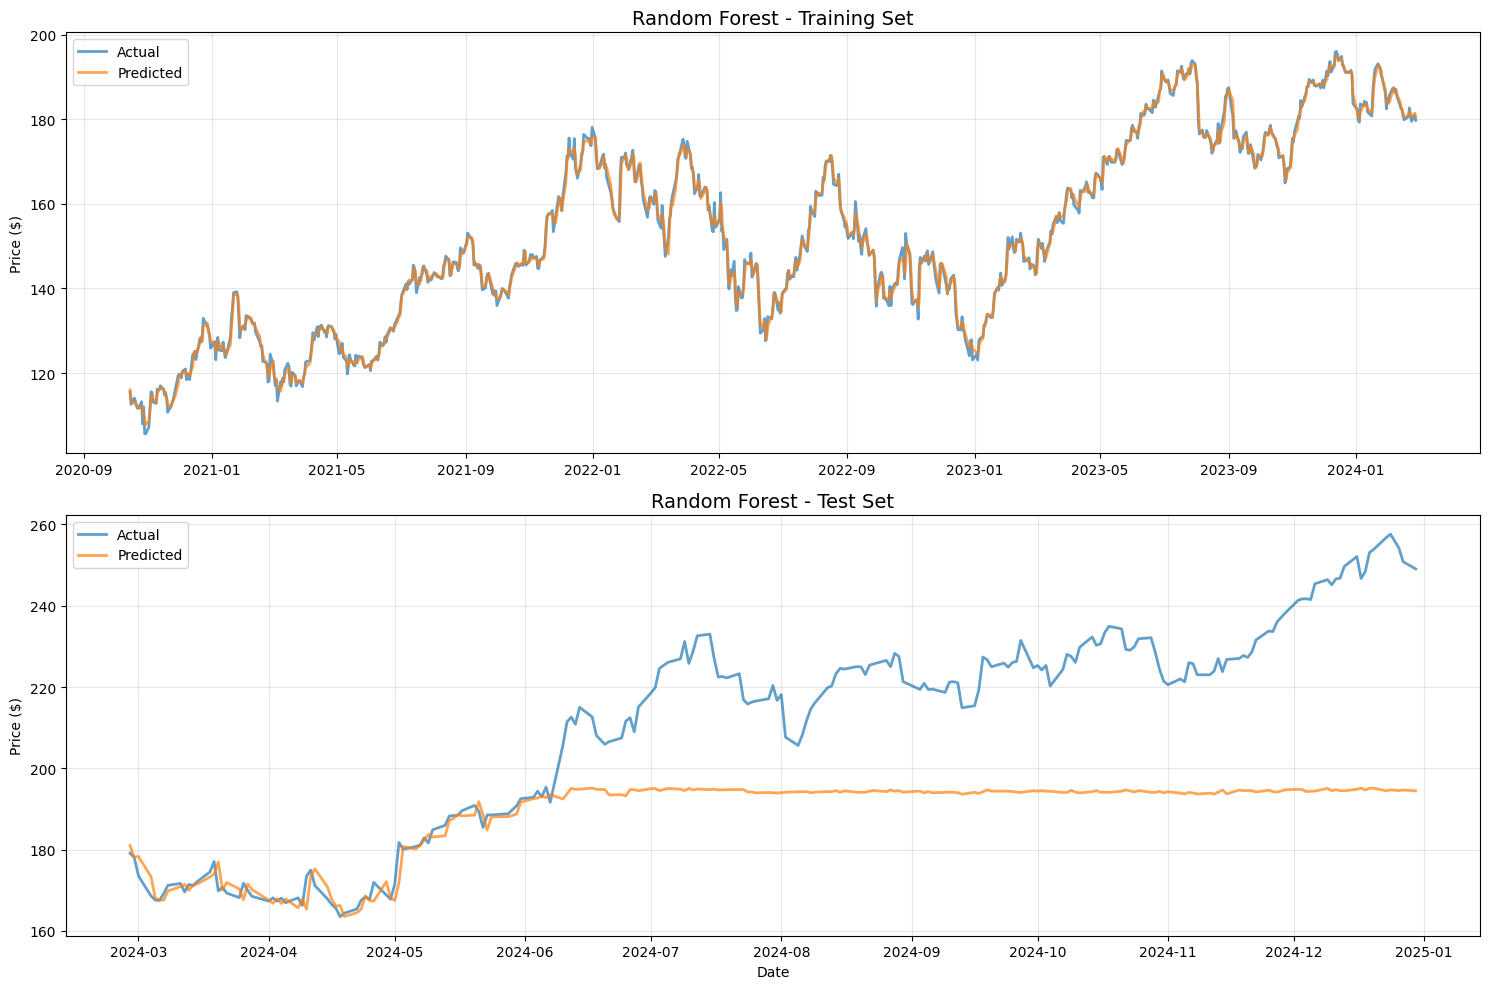

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Training set
ax1.plot(y_train.index, y_train.values, label='Actual', linewidth=2, alpha=0.7)
ax1.plot(y_train.index, y_train_pred_rf, label='Predicted', linewidth=2, alpha=0.7)
ax1.set_title('Random Forest - Training Set', fontsize=14)
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test set
ax2.plot(y_test.index, y_test.values, label='Actual', linewidth=2, alpha=0.7)
ax2.plot(y_test.index, y_test_pred_rf, label='Predicted', linewidth=2, alpha=0.7)
ax2.set_title('Random Forest - Test Set', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Price ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

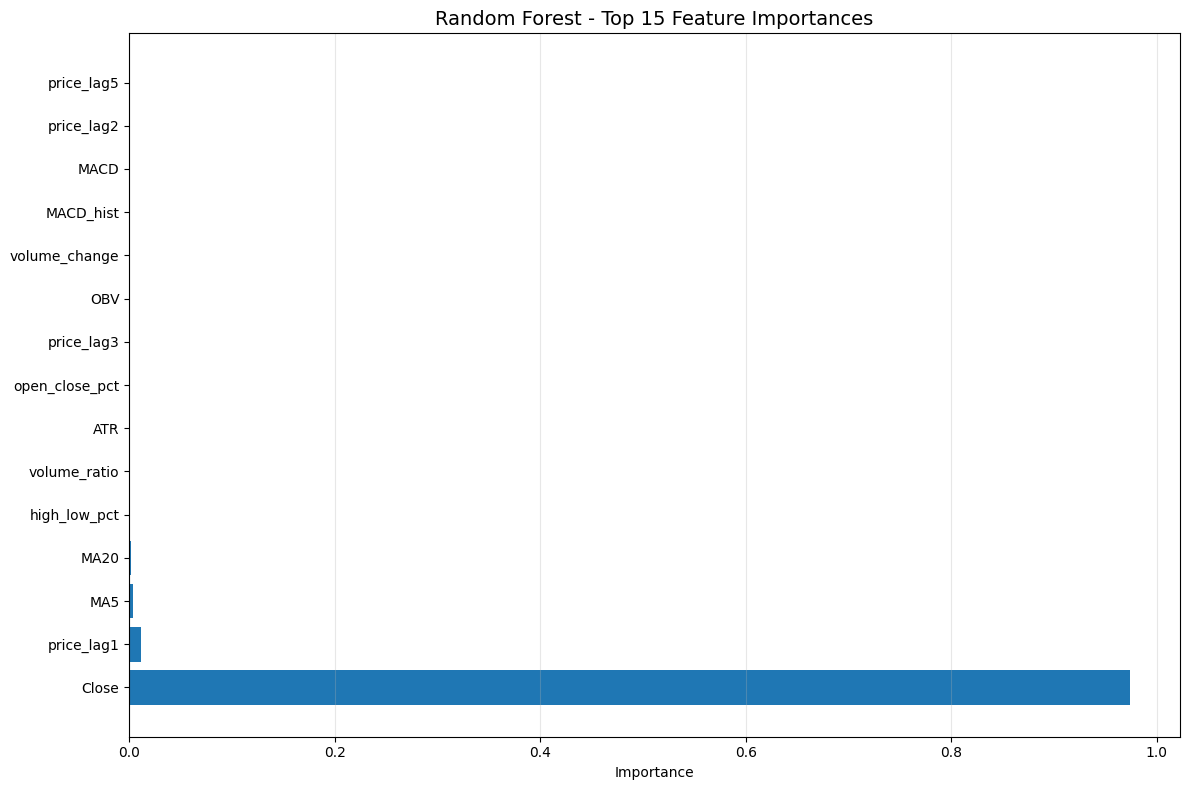

Top 10 Most Important Features:
           feature  importance
0            Close    0.974059
1       price_lag1    0.011525
7              MA5    0.003441
9             MA20    0.001486
6     high_low_pct    0.000729
23    volume_ratio    0.000692
21             ATR    0.000684
5   open_close_pct    0.000659
3       price_lag3    0.000600
25             OBV    0.000595


In [19]:
# Random Forest tells us which features it used most
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
top_features_rf = feature_importance_rf.head(15)
plt.barh(range(len(top_features_rf)), top_features_rf['importance'])
plt.yticks(range(len(top_features_rf)), top_features_rf['feature'])
plt.xlabel('Importance')
plt.title('Random Forest - Top 15 Feature Importances', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance_rf.head(10))

# Model 3 - XGBoost

In [21]:
import xgboost as xgb

print("="*60)
print("MODEL 3: XGBOOST")
print("="*60)

# Train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost...")
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model. predict(X_test_scaled)

# Calculate metrics
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

print(f"\nTraining Performance:")
print(f"  RMSE: ${train_rmse_xgb:.2f}")
print(f"  MAE: ${train_mae_xgb:.2f}")
print(f"  R² Score: ${train_r2_xgb:.4f}")

print(f"\nTest Performance:")
print(f"  RMSE: ${test_rmse_xgb:.2f}")
print(f"  MAE: ${test_mae_xgb:.2f}")
print(f"  R² Score: ${test_r2_xgb:.4f}")

print(f"\n XGBoost trained successfully!")

MODEL 3: XGBOOST
Training XGBoost...

Training Performance:
  RMSE: $0.91
  MAE: $0.70
  R² Score: $0.9983

Test Performance:
  RMSE: $30.01
  MAE: $24.13
  R² Score: $-0.3402

 XGBoost trained successfully!


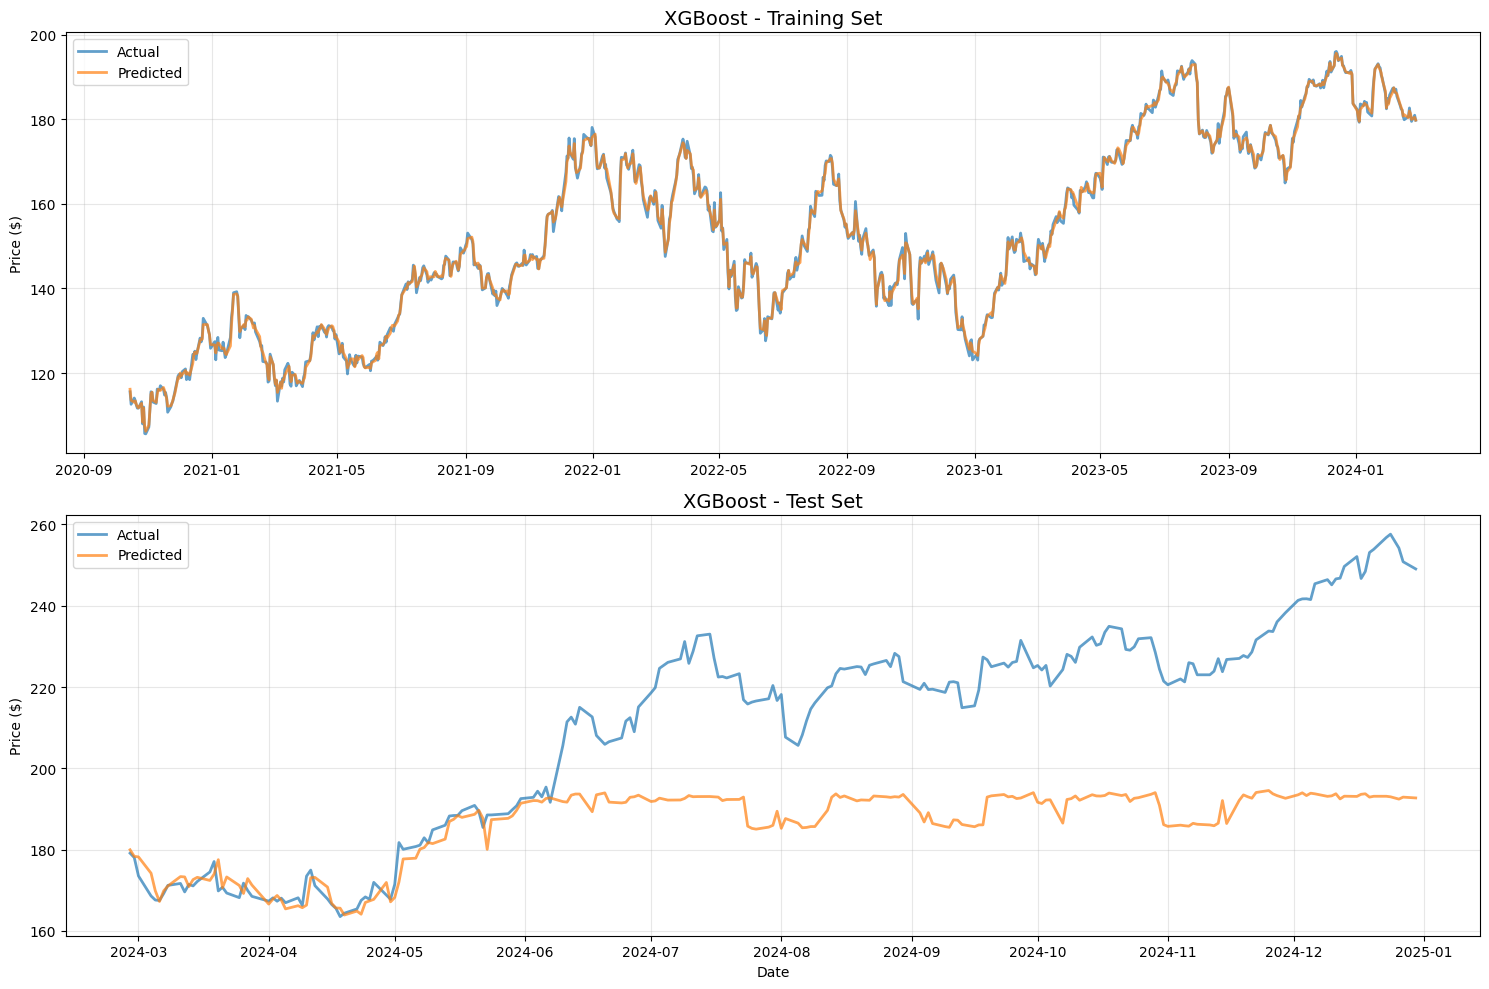

In [22]:
# Plot predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Training set
ax1.plot(y_train.index, y_train.values, label='Actual', linewidth=2, alpha=0.7)
ax1.plot(y_train.index, y_train_pred_xgb, label='Predicted', linewidth=2, alpha=0.7)
ax1.set_title('XGBoost - Training Set', fontsize=14)
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test set
ax2.plot(y_test.index, y_test.values, label='Actual', linewidth=2, alpha=0.7)
ax2.plot(y_test.index, y_test_pred_xgb, label='Predicted', linewidth=2, alpha=0.7)
ax2.set_title('XGBoost - Test Set', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Price ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare